# Logistic fits to stimulus-based condition

This script is used for model comparison for the stimulus-based logistic fits to the psychometric function in section:
"Rule- and stimulus-based biases had different effects on choices and RTs"

Produces Figure 3. Also outputs data used in all_conds_fits for Figure 2b.

In [1]:
imatlab_export_fig('print-svg')
set(groot,'defaultfigurecolor',[1 1 1]);
set(groot,'DefaultAxesFontName','Arial')

addpath('../logistic')

DATA_DIR = './data';

%models
fitspt1(1).fitmat = 'fits_lapse_pretoneOnly_full2_29-Jul-2022.mat';
fitspt1(1).model_id = 1;
fitspt1(1).mname = 'full';
fitspt1(1).nparam = 7;
fitspt1(1).ptlens = 2;
fitspt1(1).dmat_func = @make_pretone_dmat;
fitspt1(2).fitmat = 'fits_lapse_pretoneOnly_noint2_29-Jul-2022.mat';
fitspt1(2).model_id = 2;
fitspt1(2).mname = 'no interaction';
fitspt1(2).nparam = 5;
fitspt1(2).ptlens = 2;
fitspt1(2).dmat_func = @make_pretone_noint_dmat;
fitspt1(3).fitmat = 'fits_lapse_pretoneOnly_full0_07-Mar-2021.mat';
fitspt1(3).model_id = 3;
fitspt1(3).mname = 'base';
fitspt1(3).nparam = 3;
fitspt1(3).ptlens = 0;
fitspt1(3).dmat_func = @make_pretone_dmat;

fitsfull.fitmat = 'fits_lapse_pretoneOnly_full6_07-Mar-2021.mat';
fitsfull.model_id = 1;
fitsfull.mname = 'full';
fitsfull.nparam = 15;
fitsfull.ptlens = 6;
fitsfull.dmat_func = @make_pretone_dmat;

data = read_data_csv(...
    fullfile(DATA_DIR,'/priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv'));    

## PretoneOnly condition

### Modeling individual pretone effects 

To get a sense for the effect of individual pretones on the final choice, I ran a series of logistic regression models with predictors that mirror those of the DDM models. Namely, regressions were of the form

$$logit(\pi) = \beta_0 + \beta_{SNR}SNR + \sum_{i=1}^{pt_{max}}\beta_{pt_i}pt_i + \sum_{i=1}^{pt_{max}}\beta_{pt_i:|SNR|}pt_i|SNR|,$$

where $\pi$ is the probability of responding that the tone was high, $SNR$ is the signed signal-to-noise ratio of the test tone (positive = high tones, negative = low tones), $|SNR|$ is the unsigned signal-to-noise ratio of the test tone (both $SNR$ and $|SNR|$ were was z-scored to improve the stability of the fits), $pt_i$ is pretone at position $i$, where $pt_1$ is last pretone presented (the pretone immediately prior to the test tone) and $pt_{max}$ is the first pretone (the pretone furthest in time from the test tone). The SNR-dependent adaptation effect was modeled as the interaction $pt_i:|SNR|$. Pretones were coded $[0.5,-0.5]$ s.t. $\beta_{pt_i}$ is the log-odds ratio $tone_{high}:tone_{low}$ at an SNR of 0. 

In [2]:
%extract pt data and conditions
datapt = data(strcmp(data.optionName,'pretoneOnly') & ~isnan(data.choice01),:);

%set up variables (since this happens multiple places should maybe eventually be a function...)
datapt.zSNR = zscore(datapt.SNR);
datapt.nozaSNR = abs(datapt.SNR);
datapt.aSNR = zscore(datapt.nozaSNR);
datapt.pretones = cellfun(@(x) fliplr(replace(x,{'X','H','L'},{'','1','0'})), ...
    datapt.pretoneSeq,'UniformOutput',false);
%convert to numeric and recode as 0.5/-0.5
datapt.pretones = cellfun(@(x) (arrayfun(@str2double,x)-0.5),...
    datapt.pretones,'UniformOutput',false);

SNRs = unique(datapt.SNR);
ptlens = unique(datapt.pretoneLength);
ptsubj = unique(datapt.subject);

In [3]:
datapt_ave_subj = summary_stats(datapt,{'choice01'},...
    {'subject','ptC','zSNR'});

datapt_ave_all = summary_stats(datapt_ave_subj,{'mean_choice01'},...
    {'ptC','zSNR'});

%zsnrs = unique(datapt_ave_subj.zSNR);
%asnrs = unique(datapt.aSNR); 
snrs_smooth = linspace(min(SNRs), max(SNRs), 100)';

jet11 = mat2cell(jet(11),ones(1,11));
jet4 = jet11([2,5,9,11]);
jet4{3} = [128,38,38]./255; %make HL duller red
jet4{2} = [145,13,255]./255; %make LH purply
jet4r = flipud(jet4);

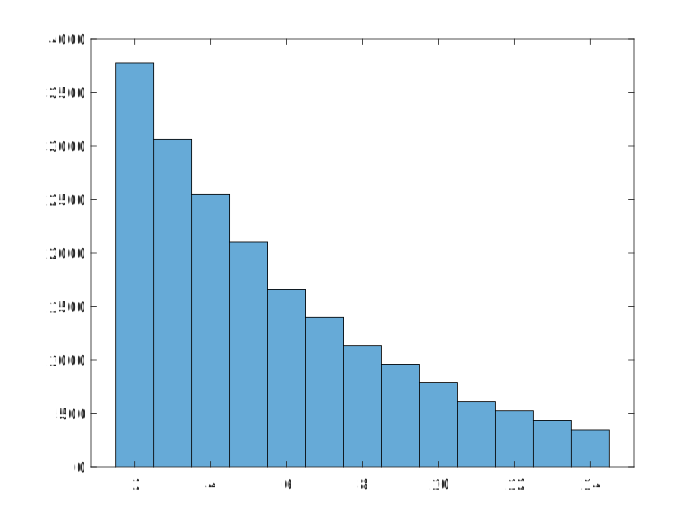

In [4]:
% first we need to establish which pretone lengths are reasonable to fit given data limits

%first overall distribution
figure();histogram(datapt.pretoneLength(~isnan(datapt.choice01)))

%now get counts
snr_len_count = table();
for s=1:length(ptsubj)
    for n=1:length(SNRs)
        this_subj = ptsubj(s);
        this_snr =SNRs(n);
        this_lens = datapt.pretoneLength(strcmp(datapt.subject,this_subj) & datapt.SNR==this_snr);
        this_counts = accumarray(this_lens,1,[14 1],[],0);
        this_counts = this_counts(2:end); %chop off count for 1 as doesn't exist in data
        this_snr_len_count = table(repmat(this_subj,13,1),repmat(this_snr,13,1),[2:14]',...
            this_counts,'VariableNames',{'subject','SNR','pretoneLength','count'});
        snr_len_count = [snr_len_count;this_snr_len_count];
    end
    clear this_subj this_snr this_lens this_counts this_snr_len_count
end

assert(height(snr_len_count)==length(SNRs)*length(ptlens)*length(ptsubj))

%now summarise
pt_SNR_len_ave = summary_stats(snr_len_count,'count',{'pretoneLength'});
pt_SNR_len_min = varfun(@min,snr_len_count,'InputVariables','count',...
    'GroupingVariables',{'pretoneLength'});
pt_SNR_len_max = varfun(@max,snr_len_count,'InputVariables','count',...
    'GroupingVariables',{'pretoneLength'});   


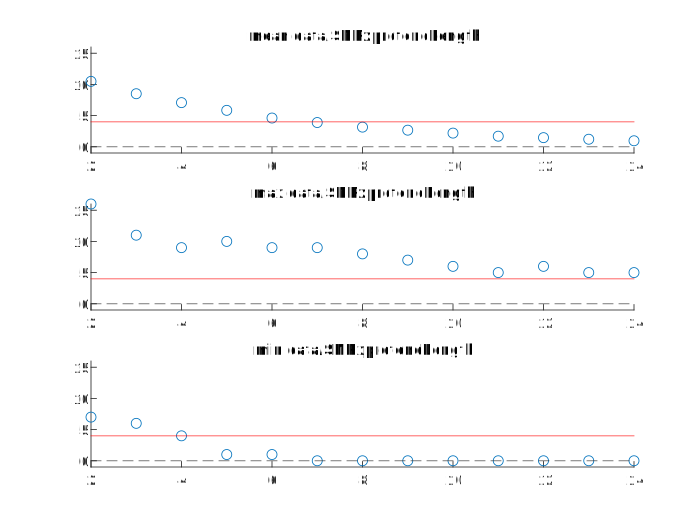

In [5]:
%now plot
figure();
subplot(3,1,1);
scatter(pt_SNR_len_ave.pretoneLength,pt_SNR_len_ave.mean_count)
title('mean data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');
subplot(3,1,2);
scatter(pt_SNR_len_max.pretoneLength,pt_SNR_len_max.max_count)
title('max data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');
subplot(3,1,3);
scatter(pt_SNR_len_min.pretoneLength,pt_SNR_len_min.min_count)
title('min data/SNRxpretoneLength')
ylim([-1 16])
yline(0,'--');
yline(4,'-r');

## Plot all models

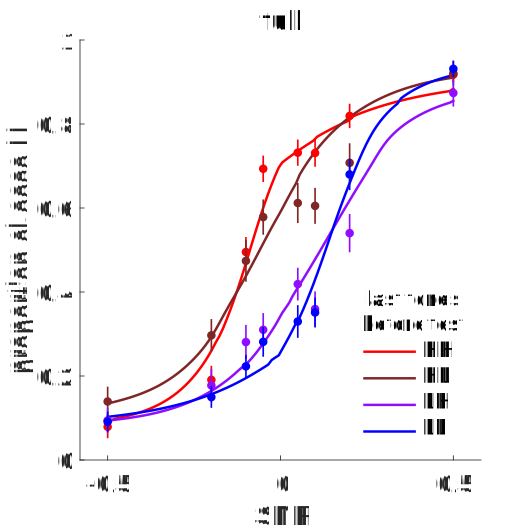

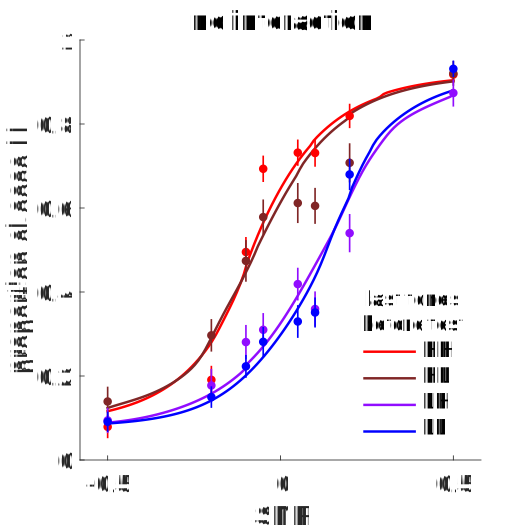

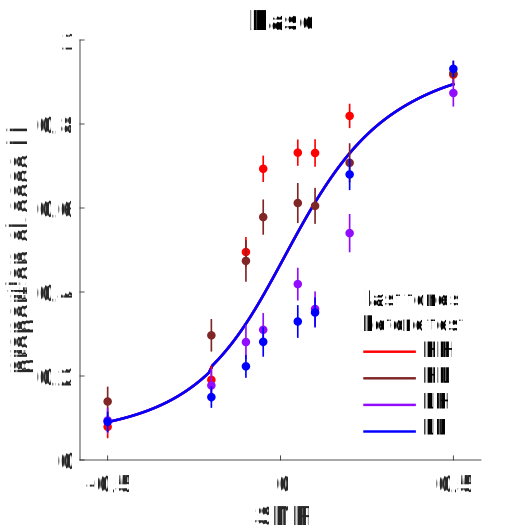

In [6]:
%compute and plot predictions for all logistic models (this takes a while b/c of all the conditions...)
this_figdim = [1 1 425 425];
%this_subplot = @(m,n,p) subtightplot(m,n,p,.12,[.16 .05],[0.12 0.05]);
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1.5)
set(groot,'DefaultErrorBarLineWidth',1)
set(groot,'DefaultErrorBarMarkerSize',14)
set(groot,'DefaultErrorBarCapSize',0)

%need this for adding ptC to predictions (ugh)
pt2ptC = {
            [-.5 -.5], 'LL';
            [-.5 .5], 'LH';
            [.5 -.5], 'HL';
            [.5 .5], 'HH'
        };

psycho_fit_ave_out = [];
for m=1:length(fitspt1)
    F = load(fullfile(DATA_DIR,fitspt1(m).fitmat));
    this_dmat_func = @(x) fitspt1(m).dmat_func(x,fitspt1(m).ptlens);
    zsnrs_smooth = (snrs_smooth - F.norms.SNR.mean)./ F.norms.SNR.sd;
    asnrs_smooth = (abs(snrs_smooth) - F.norms.aSNR.mean)./ F.norms.aSNR.sd;
    
    this_fits_pred = [];
    for s=1:height(F.fits_lapse)
        this_subj = F.fits_lapse.subject(s);
        this_fits = F.fits_lapse{s,1:fitspt1(m).nparam};
        
        %generate smooth predictions
        this_datapt = datapt(strcmp(datapt.subject,this_subj),:);
        %need to create a string variable for pretones for grouping/joining
        this_datapt.pretones01 = cellfun(@(x) num2str(x+0.5,'%d'),... 
            this_datapt.pretones,'UniformOutput',false);
        %isH is included here so we do not include predictions for tone x bias combos a subject didn't experience
        this_ptG = groupcounts(this_datapt,{'pretones01','isH'});
        this_ptG.Percent = this_ptG.Percent./100;
        this_sdata = make_smooth_data(this_datapt,...
            {'pretones'},[zsnrs_smooth asnrs_smooth snrs_smooth],{'zSNR','aSNR','SNR'});
        %ugh this is circuitous
        this_sdata.isH = double(this_sdata.SNR>0); 
        this_sdata.SNR = [];
        this_sdata.pred = logist_pred(this_sdata,this_fits,this_dmat_func,[],1);
        this_sdata.pretones01 = cellfun(@(x) num2str(x+0.5,'%d'),...
            this_sdata.pretones,'UniformOutput',false);
        this_sdata = innerjoin(this_sdata,...
            this_ptG,...
            'Keys',{'pretones01','isH'},'RightVariables','Percent');
        this_sdata.subject = repmat(this_subj,height(this_sdata),1);
        this_fits_pred = [this_fits_pred;this_sdata];
        clear this_sdata this_subj this_fits this_ptG
    end
    
    %add ptC to predictions for plotting
    this_fits_pred.ptC = repmat({''},height(this_fits_pred),1);
    for p=1:size(pt2ptC,1)
        this_fits_pred.ptC(cellfun(@(x) isequal(x(1:2),pt2ptC{p,1}),this_fits_pred.pretones)) = pt2ptC(p,2);
    end
    
    %this_fits_pred_ave = varfun(@mean,this_fits_pred,'InputVariables','pred',...
    %    'GroupingVariables',{'subject','ptC','zSNR'});
    %this version calculates weighted average according to actual proportions of 
    %trials for each pretone sequence. This gives the same result as
    %straight average for ptlen <= 2.
    this_fits_pred_ave = rowfun(@(x,w) sum(x.*w)./sum(w),this_fits_pred,...
            'InputVariables',{'pred','Percent'},...
            'GroupingVariables',{'subject','ptC','zSNR'},'OutputVariableName','mean_pred');
    this_fits_pred_ave_all = summary_stats(this_fits_pred_ave,{'mean_pred'},...
        {'ptC','zSNR'});
        
    %convert zSNR to SNR
    datapt_ave_all.SNR = (datapt_ave_all.zSNR.*F.norms.SNR.sd) + F.norms.SNR.mean;
    this_fits_pred_ave_all.SNR = (this_fits_pred_ave_all.zSNR.*F.norms.SNR.sd) + F.norms.SNR.mean;
    
    %save for output
    this_fits_pred_ave_all.model_id = repmat(fitspt1(m).model_id,height(this_fits_pred_ave_all),1);
    this_fits_pred_ave_all.mname = repmat(cellstr(fitspt1(m).mname),height(this_fits_pred_ave_all),1);
    psycho_fit_ave_out = [psycho_fit_ave_out;this_fits_pred_ave_all];

    figure('Position',this_figdim);hold on;
    h_psychm = psycho_plot(this_fits_pred_ave_all,'ptC','-','mean_mean_pred',[],0,'SNR');
    [h_psychm.Color] = jet4r{:}; 
    h_psych = psycho_plot(datapt_ave_all,'ptC','.','mean_mean_choice01','sem_mean_choice01',0,'SNR');
    [h_psych.Color] = jet4r{:}; 

    xlabel('SNR')
    ylabel('proportion choose H')
    xlim([-.58 .58])
    ylim([0 1])
    title(fitspt1(m).mname)
    
    psychpt_leg = cellstr(unique(datapt_ave_all.ptC(~isundefined(datapt_ave_all.ptC))));
    legendflex(psychpt_leg,'anchor',[5 5],'buffer',[-12,10],'box','off', ...
        'title',{'\fontsize{13}last tones';'\fontsize{13}before test'});
            
    clear this_fits_pred this_fits_pred_ave_all F; datapt_ave_all.SNR = [];   

end
set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultErrorBarLineWidth','factory')
set(groot,'DefaultErrorBarMarkerSize','factory')
set(groot,'DefaultErrorBarCapSize','factory')

In [7]:
%output average fits for plotting elsewhwere
if false
    save(fullfile(DATA_DIR,['psycho_fits_pretone_ave_' date() '.mat']),'psycho_fit_ave_out');
end

## model comparison

In [8]:
llept1 = table();
for i=1:length(fitspt1)
    F = load(fullfile(DATA_DIR,fitspt1(i).fitmat));
    F.fit_stats.model_id = repmat(fitspt1(i).model_id,height(F.fit_stats),1);
    F.fit_stats.mname = cellstr(repmat(fitspt1(i).mname,height(F.fit_stats),1));
    llept1 = [llept1; F.fit_stats];
    clear F
end
%compute AIC
llept1.aic = 2.*llept1.nparam - 2.*llept1.LL;

%compute BIC
sampsize = varfun(@length,datapt,'InputVariables','choice01','GroupingVariables','subject');
llept1 = join(llept1,sampsize,'Keys','subject','RightVariables','GroupCount');
llept1.bic = log(llept1.GroupCount).*llept1.nparam - 2.*llept1.LL;

In [9]:
%Group averages
llept1_ave = summary_stats(llept1,{'LL','aic','bic'},{'model_id','mname','nparam'})


llept1_ave =

  3x13 table

    model_id          mname           nparam    GroupCount    mean_LL    mean_aic    mean_bic    std_LL    std_aic    std_bic    sem_LL    sem_aic    sem_bic
    ________    __________________    ______    __________    _______    ________    ________    ______    _______    _______    ______    _______    _______

       1        {'full'          }      7           45        -185.06     384.13      412.57     54.072    108.14     108.12     8.0606    16.121     16.117 
       2        {'no interaction'}      5           45        -188.62     387.24      407.56     53.523    107.05     107.03     7.9787    15.957     15.955 
       3        {'base'          }      3           45         -217.5     440.99      453.18     38.559    77.117     77.123      5.748    11.496     11.497 



In [10]:
%FINAL

disp('AIC')
fprintf('no int - full: %.2f\n',mean(llept1.aic(llept1.model_id==2) - llept1.aic(llept1.model_id==1)));
fprintf('base - no int: %.2f\n',mean(llept1.aic(llept1.model_id==3) - llept1.aic(llept1.model_id==2)));
fprintf('base - full: %.2f\n',mean(llept1.aic(llept1.model_id==3) - llept1.aic(llept1.model_id==1)));

disp('BIC')
fprintf('no int - full: %.2f\n',mean(llept1.bic(llept1.model_id==2) - llept1.bic(llept1.model_id==1)));
fprintf('base - no int: %.2f\n',mean(llept1.bic(llept1.model_id==3) - llept1.bic(llept1.model_id==2)));
fprintf('base - full: %.2f\n',mean(llept1.bic(llept1.model_id==3) - llept1.bic(llept1.model_id==1)));

AIC
no int - full: 3.11
base - no int: 53.75
base - full: 56.86
BIC
no int - full: -5.01
base - no int: 45.62
base - full: 40.61


In [11]:
%now compute likelihood ratio test (and AIC/BIC diffs) per subject for targeted comparisons
LRT_comps = [
            1 2;
            2 3
            ];

LRT_subj= table();
subj_pc = unique(llept1.subject);
for s=1:length(subj_pc)
    this_subj = subj_pc(s);
    this_lle = llept1(strcmp(llept1.subject,this_subj),:);
    for i=1:size(LRT_comps,1)
        umod = this_lle(this_lle.model_id==LRT_comps(i,1),:); %unrestricted model in matlab lratiotest parlance
        rmod = this_lle(this_lle.model_id==LRT_comps(i,2),:); %restricted model in matlab lratiotest parlance
        this_dof = umod.nparam-rmod.nparam;
        [h,p,stat,cValue] = lratiotest(umod.LL,rmod.LL,this_dof);
        this_lrt = table(h,p,stat,cValue);
        this_lrt.dof = this_dof;
        this_lrt.subject = this_subj;
        this_lrt.comparison = cellstr(sprintf('%d-%d',umod.model_id,rmod.model_id));
        this_lrt.daic = -(umod.aic - rmod.aic); %by convention positive will be evidence for full model (to go along w/ LLR)
        this_lrt.dbic = -(umod.bic - rmod.bic);
        LRT_subj = [LRT_subj;this_lrt];
    end
    clear this_lrt this_lle umod rmod this_subj this_dof
end

LRT_subj.daic01 = double(LRT_subj.daic) > 0;
LRT_subj.dbic01 = double(LRT_subj.dbic) > 0;
LRT_subj.LLR = LRT_subj.stat./2;

In [12]:
LRT_ave = varfun(@mean,LRT_subj,'InputVariables',{'h','LLR','daic','daic01','dbic','dbic01'},...
    'GroupingVariables','comparison')
LRT_ave.model_id = cellfun(@(x) str2double(x{1}),regexp(LRT_ave.comparison,'(\d)-\d','tokens','once'));    
    
fprintf('percent subjects best fit (chi-sq) full vs. shared: %.2f\n',...
    LRT_ave.mean_h(strcmp(LRT_ave.comparison,'1-2')))
fprintf('percent subjects best fit (chi-sq) shared vs. no prior: %.2f\n',...
    LRT_ave.mean_h(strcmp(LRT_ave.comparison,'2-3')))


LRT_ave =

  2x8 table

    comparison    GroupCount    mean_h     mean_LLR    mean_daic    mean_daic01    mean_dbic    mean_dbic01
    __________    __________    _______    ________    _________    ___________    _________    ___________

     {'1-2'}          45        0.48889      3.557       3.114        0.66667       -5.0123       0.22222  
     {'2-3'}          45            0.8     28.875       53.75        0.84444        45.623       0.62222  

percent subjects best fit (chi-sq) full vs. shared: 0.49
percent subjects best fit (chi-sq) shared vs. no prior: 0.80


To use the original INDVAR values as table variable names, set 'VariableNamingRule' to 'preserve'.
---
Date: 29-Aug-2022 16:15:05
VB converged in 19 iterations (took ~9 sec).
Dimensions:
     - subjects: n=45
     - models: K=3
Posterior probabilities:
     - RFX: p(H1|y)= 1.000
     - null: p(H0|y)= 0.000

ans =

  3x3 table

          mname              Ef           pep    
    __________________    _________    __________

    {'full'          }      0.79982       0.99998
    {'no interaction'}      0.19074    9.3021e-06
    {'base'          }    0.0094391    9.3021e-06



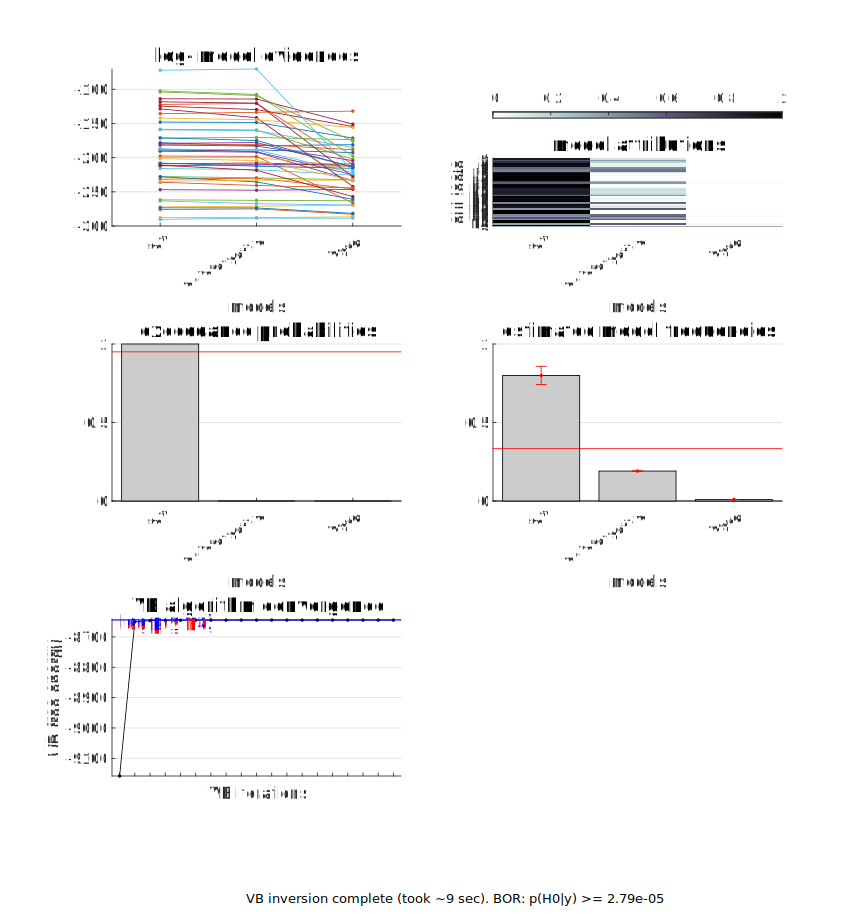

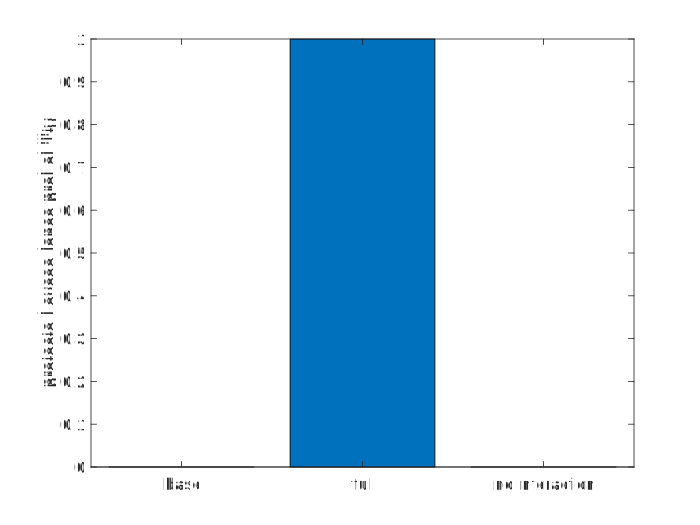

In [13]:
%FINAL

%% now let's look at exceedance probability
llept1_VBA = llept1(:,{'subject','mname','aic'});
%Stephan et al 2009 AIC is normal AIC/-2 ie log(llept1) - k; this is what
%the BMC function expects
llept1_VBA.aic = llept1_VBA.aic./-2;
llept1_VBA = unstack(llept1_VBA,'aic','mname');
llept1_VBA = movevars(llept1_VBA,'base','After','noInteraction');

opts.MaxIter = 1e4;
opts.modelNames = llept1_VBA.Properties.VariableNames(2:end);

[posterior,out] = VBA_groupBMC(llept1_VBA{:,2:end}',opts);
%compute protected EP: Rigoux et al., 2014. Code from:
%http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

out_table = table(out.options.modelNames',out.ep',out.PEP',out.Ef,...
    'VariableNames',{'mname','ep','pep','Ef'});
out_table.mname = strrep(out_table.mname,'noInteraction','no interaction');

out_table(:,{'mname','Ef','pep'})
    
%plot protected exceedance probabilities
figure();bar(categorical(out_table.mname),out_table.pep)
%xticklabels(llept1_sum.mname)
ylabel('protected exceedance probability')

In [14]:
%FINAL (Table 1)

%note, unlike for the DDM fits, the columns past pep relate to how the model on that line fit compared to the model 
%one step below, not all compared to full model

comp_table = llept1_ave(:,{'model_id','mname','nparam','mean_aic','mean_bic'});
comp_table = innerjoin(comp_table,out_table,'Keys','mname','RightVariables','pep');
comp_table = outerjoin(comp_table,LRT_ave,'Keys','model_id','RightVariables',...
    {'mean_h','mean_LLR','mean_daic01','mean_dbic01'});
comp_table(:,~ismember(comp_table.Properties.VariableNames,{'model_id'}))


ans =

  3x9 table

          mname           nparam    mean_aic    mean_bic       pep        mean_h     mean_LLR    mean_daic01    mean_dbic01
    __________________    ______    ________    ________    __________    _______    ________    ___________    ___________

    {'full'          }      7        384.13      412.57        0.99998    0.48889      3.557       0.66667        0.22222  
    {'no interaction'}      5        387.24      407.56     9.3021e-06        0.8     28.875       0.84444        0.62222  
    {'base'          }      3        440.99      453.18     9.3021e-06        NaN        NaN           NaN            NaN  



### Parsing out bias vs. adaptation

In [15]:
F = load(fullfile(DATA_DIR,fitsfull.fitmat));
ptfx = F.pt_total_fx; clear F


%what is the differential effect of SNR X - SNR 0? 
%(this is just recentering the main effect and interaction since SNR was mean centered, and
%we want bias (the main effect) to be pretone effect at SNR==0

ptfx0 = ptfx(ptfx.aSNR==0,{'subject','total_fx'});
ptfx0.Properties.VariableNames{'total_fx'} = 'total_fx0';
ptfxdiff = join(ptfx(ptfx.aSNR~=0,:),ptfx0,'Keys','subject');
ptfxdiff.total_diff = ptfxdiff.total_fx - ptfxdiff.total_fx0;
%clear ptfx0
ptfxdiff.total_fx0 = [];

ptfx0_med = varfun(@median,ptfx0,'InputVariables',...
    {'total_fx0'});
ptfxdiff_med = varfun(@median,ptfxdiff,'InputVariables',...
    {'total_diff'},'GroupingVariables','aSNR');
head(ptfxdiff_med);

In [16]:
%%now construct bootstrap confidence intervals

nsamp = 10000;

%bootstrap for bias
boot_bias = [];
for i=1:nsamp
    this_boot = datasample(ptfx0.total_fx0,height(ptfx0),1);
    %debugging
    %{
    for j=1:6
        assert(all(ismember(this_boot(:,j),ptfx0.total_fx0(:,j))))
    end
    %}
    this_bias_med = table(i,median(this_boot,1),'VariableNames',{'n','median'});
    boot_bias = [boot_bias;this_bias_med];
end

%bootstrap for adapt
aSNRs = unique(ptfxdiff.aSNR);
%just do the bootstrap for the actual Betas and then scale...when construct CI
adapt_weights = ptfxdiff.total_diff(ptfxdiff.aSNR==.5,:)./.5;
boot_adapt = [];
for i=1:nsamp
    this_boot = datasample(adapt_weights,size(adapt_weights,1),1);
    %debugging
    %{
    for j=1:6
        assert(all(ismember(this_boot(:,j),adapt_weights(:,j))))
    end
    %}
    this_adapt_med = table(i,median(this_boot,1),'VariableNames',{'n','median'});
    boot_adapt = [boot_adapt;this_adapt_med];
end
    
%get bootstrapped confidence intervals (find index of upper/lower CI)
alpha = .05;
CI_lower = nsamp*(alpha/2);
CI_upper = nsamp*(1-alpha/2);

%first for bias
ptfx0_med.CI_lower = nan(1,6);
ptfx0_med.CI_upper = nan(1,6);
for i=1:6
    this_med = sort(boot_bias.median(:,i));
    ptfx0_med.CI_lower(i) = this_med(CI_lower);
    ptfx0_med.CI_upper(i) = this_med(CI_upper);
end
%center CIs on true medians for errorbar func
ptfx0_med.CI_lower = ptfx0_med.median_total_fx0 - ptfx0_med.CI_lower;
ptfx0_med.CI_upper = ptfx0_med.CI_upper - ptfx0_med.median_total_fx0;


%now for adapt
ptfxdiff_med.CI_lower = nan(height(ptfxdiff_med),6);
ptfxdiff_med.CI_upper = nan(height(ptfxdiff_med),6);

for s=1:length(aSNRs)
    for i=1:6
        this_med = sort(boot_adapt.median(:,i).*aSNRs(s));
        ptfxdiff_med.CI_lower(s,i) = this_med(CI_lower);
        ptfxdiff_med.CI_upper(s,i) = this_med(CI_upper);
    end
    %center CIs on true medians for errorbar func
    ptfxdiff_med.CI_lower(s,:) = ptfxdiff_med.median_total_diff(s,:) - ptfxdiff_med.CI_lower(s,:);
    ptfxdiff_med.CI_upper(s,:) = ptfxdiff_med.CI_upper(s,:) - ptfxdiff_med.median_total_diff(s,:);
end

#### Figure 3

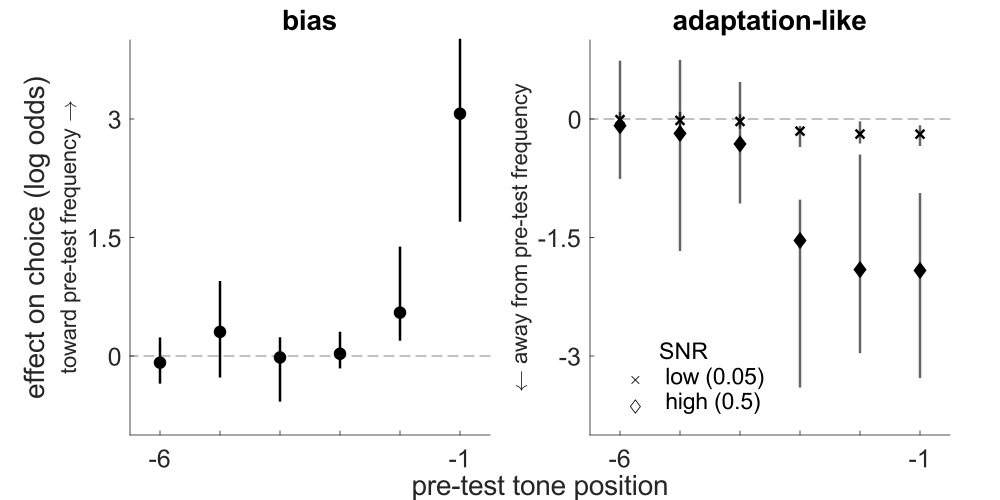

In [17]:
to_print = true;
flip_ax = true;
if to_print
    set(groot,'DefaultAxesFontSize',15)
    set(groot,'DefaultErrorBarCapSize',0)
    set(groot,'DefaultErrorBarMarkerFaceColor','auto')
    this_subplot = @(m,n,p) subtightplot(m,n,p,.1,[.13,.08],[0.13 0.05]);
else
    this_subplot = subplot;
end

ptpos = 1:size(ptfx0_med.median_total_fx0,2);
lxlim = [min(ptpos)-0.5 max(ptpos)+.5];
lxticks = min(ptpos):max(ptpos);
if flip_ax
    lxticklabs = {num2str(-min(ptpos)),'','','','',num2str(-max(ptpos))};
else
    lxticklabs = {num2str(min(ptpos)),'','','','',num2str(max(ptpos))};
end

figure('Position',[0 0 800 400])
this_subplot(1,2,1);hold on;
if flip_ax
    set(gca,'xdir','reverse')
end
errorbar(ptpos,ptfx0_med.median_total_fx0,ptfx0_med.CI_lower,ptfx0_med.CI_upper,...
    'ok','LineWidth',1.5)
title('bias');
if ~to_print
    xlabel('tone position (reversed)')
end
%ylabel('high/low (log odds)')
ylabel({'effect on choice (log odds)','\fontsize{13}toward pre-test frequency \rightarrow'})
xlim(lxlim)
xticks(lxticks)
xticklabels(lxticklabs)
%ylim([-1 2])
ylim([-1 4])
yticks([0:1.5:6])
yline(0,'--');


this_subplot(1,2,2);hold on;
if flip_ax
    set(gca,'xdir','reverse')
end
SNR_disp = [1,4];
line_levels = [.85 NaN NaN 1.5]; %[.5:.4:1.7];
marker_levels = {'x',NaN,NaN,'d'};
for s=SNR_disp %1:height(ptfxdiff_med)
    h=errorbar(ptpos,ptfxdiff_med.median_total_diff(s,:),...
    ptfxdiff_med.CI_lower(s,:),ptfxdiff_med.CI_upper(s,:),[marker_levels{s} 'k'],...
    'LineWidth',1.5);
    %'LineWidth',line_levels(s),'MarkerSize',line_levels(s)*5+1); %1.5);
    % Set transparency level (0:1)
    alpha = 0.6;   
    % Set transparency (undocumented)
    set([h.Bar, h.Line], 'ColorType', 'truecoloralpha', 'ColorData',...
        [h.Line.ColorData(1:3); 255*alpha]);
end
xlim(lxlim)
xticks(lxticks)
xticklabels(lxticklabs)
%ylim([-2 .5])
ylim([-4 1])
yticks([-6:1.5:1])
yline(0,'--');
ylabel('\fontsize{13}\leftarrow away from pre-test frequency')
title('adaptation-like')
if ~to_print
    xlabel('tone position (reversed)');
end

%adapt_leg = arrayfun(@num2str,ptfxdiff_med.aSNR(SNR_disp),'UniformOutput',false);
adapt_leg = {'low (0.05)','high (0.5)'};
legendflex(adapt_leg,...
    'title','\fontsize{14}SNR','box','off',...
    'anchor',[7 7],'buffer',[10 10])

if to_print
    %suplabel('tone position (reversed)','x',[.08 .14 .84 .84]);
    suplabel('pre-test tone position','x',[.12 .14 .84 .84]);
    set(groot,'DefaultAxesFontSize','factory')
    set(groot,'DefaultErrorBarCapSize','factory')
    set(groot,'DefaultErrorBarMarkerFaceColor','factory')
end